## Client Meeting Notes

**Project:** Fine-tuning engineering system (focus on pollution reduction)
**Client:** Energy provider in Turkey
**Date:** [insert meeting date]
**Attendees:** [Team + Client’s engineering manager]

---

### 1. Objective

* Main goal: **Reduce nitrogen oxide (NOx) emissions** from gas turbine operations.
* Secondary pollutant: **Carbon monoxide (CO)** also needs monitoring.

---

### 2. Current System & Data

* Equipment: Gas turbines in operation.
* Sensors already in place to measure NOx and CO.
* Data available: **Hourly measurements for 2 years** (averaged).
* Energy range: **130–136 MWh normal range**, up to **160 MWh in higher load conditions**.
* Ambient variables (e.g., temperature, weather) also influence emissions.

---

### 3. Processes to Investigate / Fine-tune

* Turbine combustion processes (e.g., burner settings, firing temperature).
* SCR (if applicable) or other abatement tuning for NOx.
* Impact of **ambient/weather conditions** on emissions.
* Review control variables: CDP, TKI, TIT, TAT (pressure, inlet/outlet temps, turbine parameters).

---

### 4. Deliverables Requested

* **Report and code** (well documented).
* Analysis in **R and Python**.
* Recommendations on “what should be done under different weather/ambient conditions.”
* Delivery deadline: **By December**.

---

### 5. Stakeholder & Communication

* Client contact: **Engineering Manager**.
* Preferred communication: **Email** (need to confirm details).
* They requested a **general overview** presentation before going into technical details.



| Column   | Likely Meaning (Gas Turbine Context)                          |
| -------- | ------------------------------------------------------------- |
| **AT**   | Ambient Temperature (°C)                                      |
| **AP**   | Ambient Pressure (mbar)                                       |
| **AH**   | Ambient Humidity (%)                                          |
| **AFDP** | Air Filter Differential Pressure (inches of water or similar) |
| **GTEP** | Gas Turbine Exhaust Pressure (bar)                            |
| **TIT**  | Turbine Inlet Temperature (°C)                                |
| **TAT**  | Turbine After Temperature (exhaust temperature, °C)           |
| **TEY**  | Turbine Energy Yield / Power Output (MW)                      |
| **CDP**  | Compressor Discharge Pressure (bar)                           |
| **CO**   | Carbon Monoxide emissions (ppm or mg/Nm³)                     |
| **NOX**  | Nitrogen Oxide emissions (ppm or mg/Nm³) – **main target**    |


# Project: Gas Turbine NOx EDA
Goal: Understand drivers of NOx (and CO) to inform tuning.
Data: Hourly 2-year turbine dataset. Variables include ambient, pressures, temps, power, emissions.
Outputs: Clean EDA plots, correlations, early feature importance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Change the path if your file is elsewhere
PATH = "TurbineGroup2.csv"
df = pd.read_csv(PATH)

print(df.shape)
df.head()


(14310, 11)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,9.3779,1020.1,90.262,2.3927,19.166,1043.6,541.16,110.16,10.564,9.3472,98.741
1,9.2985,1019.9,89.934,2.3732,19.119,1039.9,538.94,109.23,10.572,11.0160,104.290
2,9.1337,1019.8,89.868,2.3854,19.178,1041.0,539.47,109.62,10.543,10.7500,103.470
3,8.9715,1019.3,89.490,2.3825,19.180,1037.1,536.89,108.88,10.458,12.2870,108.810
4,9.0157,1019.1,89.099,2.4044,19.206,1043.5,541.25,110.09,10.464,9.8229,100.020


We map column names to gas-turbine meanings to keep analysis aligned:

AT = Ambient Temperature (°C)
AP = Ambient Pressure (mbar)
AH = Ambient Humidity (%)
AFDP = Air Filter Differential Pressure
GTEP = Gas Turbine Exhaust Pressure
TIT = Turbine Inlet Temperature (°C)
TAT = Turbine After/Exhaust Temperature (°C)
TEY = Power Output / Energy Yield (MW/MWh proxy)
CDP = Compressor Discharge Pressure
CO = Carbon Monoxide emissions
NOX = Nitrogen Oxides emissions (target)


In [4]:
var_dict = {
    "AT":"Ambient Temperature (°C)",
    "AP":"Ambient Pressure (mbar)",
    "AH":"Ambient Humidity (%)",
    "AFDP":"Air Filter Differential Pressure",
    "GTEP":"Gas Turbine Exhaust Pressure",
    "TIT":"Turbine Inlet Temperature (°C)",
    "TAT":"Turbine Exhaust Temperature (°C)",
    "TEY":"Power Output / Energy Yield",
    "CDP":"Compressor Discharge Pressure",
    "CO":"Carbon Monoxide emissions",
    "NOX":"Nitrogen Oxides emissions (target)"
}
pd.Series(var_dict)


AT                Ambient Temperature (°C)
AP                 Ambient Pressure (mbar)
AH                    Ambient Humidity (%)
AFDP      Air Filter Differential Pressure
GTEP          Gas Turbine Exhaust Pressure
TIT         Turbine Inlet Temperature (°C)
TAT       Turbine Exhaust Temperature (°C)
TEY            Power Output / Energy Yield
CDP          Compressor Discharge Pressure
CO               Carbon Monoxide emissions
NOX     Nitrogen Oxides emissions (target)
dtype: object

## Check dtypes, missing values, duplicates, and basic stats to validate data readiness.


In [5]:
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", int(df.duplicated().sum()))
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14310 entries, 0 to 14309
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      14310 non-null  float64
 1   AP      14310 non-null  float64
 2   AH      14310 non-null  float64
 3   AFDP    14310 non-null  float64
 4   GTEP    14310 non-null  float64
 5   TIT     14310 non-null  float64
 6   TAT     14310 non-null  float64
 7   TEY     14310 non-null  float64
 8   CDP     14310 non-null  float64
 9   CO      14310 non-null  float64
 10  NOX     14310 non-null  float64
dtypes: float64(11)
memory usage: 1.2 MB
None

Missing values per column:
 AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

Duplicate rows: 7


,count,mean,std,min,25%,50%,75%,max
AT,14310.0,17.909974,6.935813,0.28985,12.467500,17.67800,23.41850,34.1890
AP,14310.0,1012.192015,6.136508,989.38000,1008.200000,1011.90000,1016.10000,1031.4000
AH,14310.0,81.303128,13.599895,25.98700,72.437250,84.28850,92.16050,100.1900
AFDP,14310.0,3.805274,0.767639,2.15170,3.250500,3.80455,4.20030,6.9779
GTEP,14310.0,25.423679,4.043840,17.93900,22.931000,25.07500,26.77200,36.9500
TIT,14310.0,1080.202586,17.038717,1002.90000,1068.500000,1083.20000,1094.20000,1100.9000
TAT,14310.0,546.709959,6.209894,511.04000,546.240000,549.91000,550.04000,550.6000
TEY,14310.0,132.538315,15.041731,100.03000,122.540000,133.53000,136.92000,172.9600
CDP,14310.0,11.997733,1.044559,9.85180,11.328250,11.92550,12.39275,14.8670
CO,14310.0,2.401932,2.215921,0.00164,1.253725,1.70665,2.62500,35.0450


### Inspect distributions for NOX, CO, temps, pressures, power. Identify skew and unusual ranges.


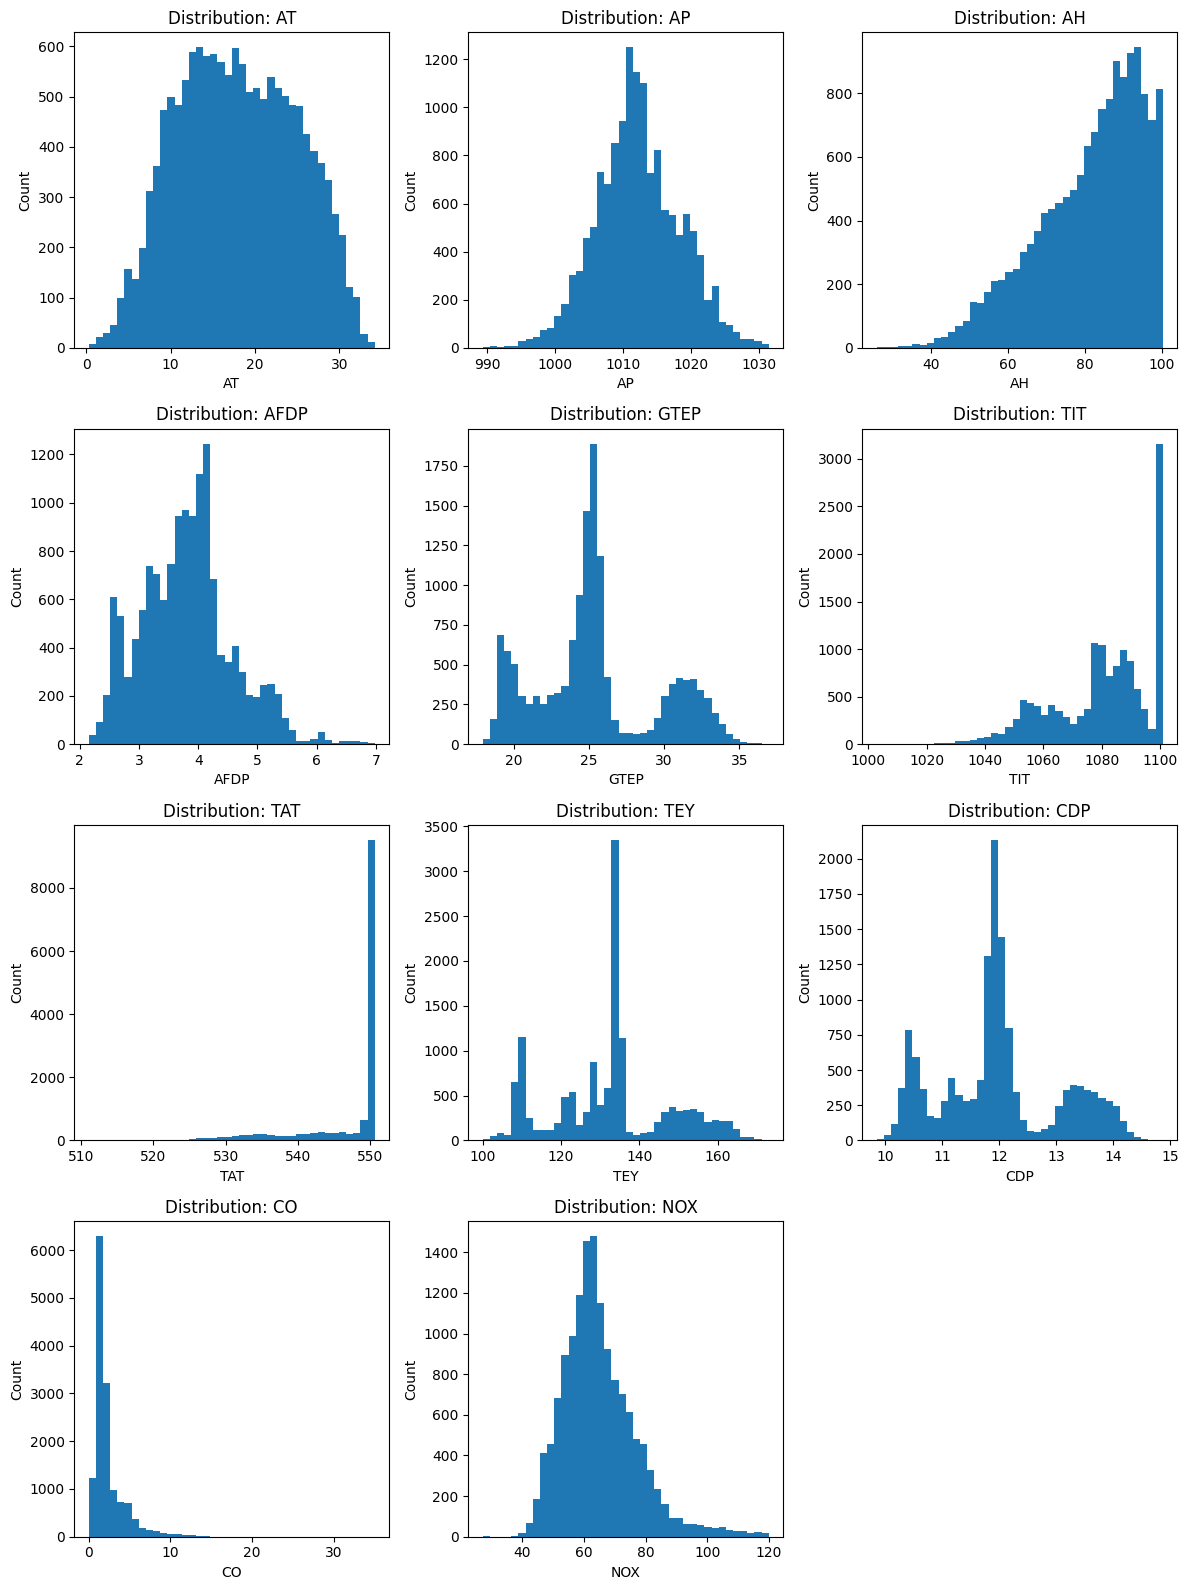

In [7]:
cols = df.columns.tolist()
n = len(cols)
rows = int(np.ceil(n/3))
fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))
axes = axes.flatten()

for i, c in enumerate(cols):
    axes[i].hist(df[c].values, bins=40)
    axes[i].set_title(f"Distribution: {c}")
    axes[i].set_xlabel(c); axes[i].set_ylabel("Count")

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()
plt.show()




1. **Ambient conditions (AT, AP, AH)**

   * Temperature varies widely (0–35°C).
   * Pressure is mostly stable around 1010 mbar.
   * Humidity is usually high (above 70%).

2. **Filters & pressures (AFDP, CDP, GTEP)**

   * Filter pressure (AFDP) shows different peaks → sometimes filters are clean, sometimes clogged.
   * Compressor pressure (CDP) runs in distinct ranges → likely different operating modes.
   * Exhaust pressure (GTEP) also shows clear clusters → different load levels.

3. **Temperatures (TIT, TAT)**

   * Turbine inlet temperature (TIT) is often pushed close to its limit (1100°C).
   * Exhaust temperature (TAT) is very tightly controlled around 550°C.

4. **Power output (TEY)**

   * The turbine doesn’t run at all values smoothly, but in “steps” (like around 120 MW, 135 MW, etc.) → matches load setpoints.

5. **Emissions (CO, NOX)**

   * CO is almost always near zero but spikes occasionally → happens at low load or unstable combustion.
   * NOx mostly sits between 60–80 ppm, with a bell-curve shape → steady but driven by high temperatures.

---

✅ **Overall observations:**

* The turbine runs in **distinct modes** rather than smoothly across all ranges.
* **TIT (inlet temp)** is the biggest driver of NOx.
* **CO and NOx trade off** → when one is high, the other tends to be low.
* Ambient conditions (especially humidity) likely explain some variation in NOx.



## Compute Pearson correlations. Visualize correlation matrix. Rank absolute correlations with NOX to shortlist drivers.


In [8]:
corr = df.corr(numeric_only=True)
corr.round(3)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,1.000,-0.339,-0.509,0.575,0.067,0.183,0.254,-0.079,0.037,-0.138,-0.576
AP,-0.339,1.000,-0.024,-0.089,0.079,0.012,-0.207,0.117,0.105,-0.014,0.188
AH,-0.509,-0.024,1.000,-0.325,-0.213,-0.257,0.059,-0.141,-0.206,0.172,0.097
AFDP,0.575,-0.089,-0.325,1.000,0.678,0.678,-0.312,0.592,0.667,-0.426,-0.407
GTEP,0.067,0.079,-0.213,0.678,1.000,0.898,-0.707,0.976,0.992,-0.569,-0.089
TIT,0.183,0.012,-0.257,0.678,0.898,1.000,-0.408,0.919,0.919,-0.703,-0.124
TAT,0.254,-0.207,0.059,-0.312,-0.707,-0.408,1.000,-0.674,-0.701,0.034,-0.236
TEY,-0.079,0.117,-0.141,0.592,0.976,0.919,-0.674,1.000,0.988,-0.601,0.000
CDP,0.037,0.105,-0.206,0.667,0.992,0.919,-0.701,0.988,1.000,-0.577,-0.054
CO,-0.138,-0.014,0.172,-0.426,-0.569,-0.703,0.034,-0.601,-0.577,1.000,0.372


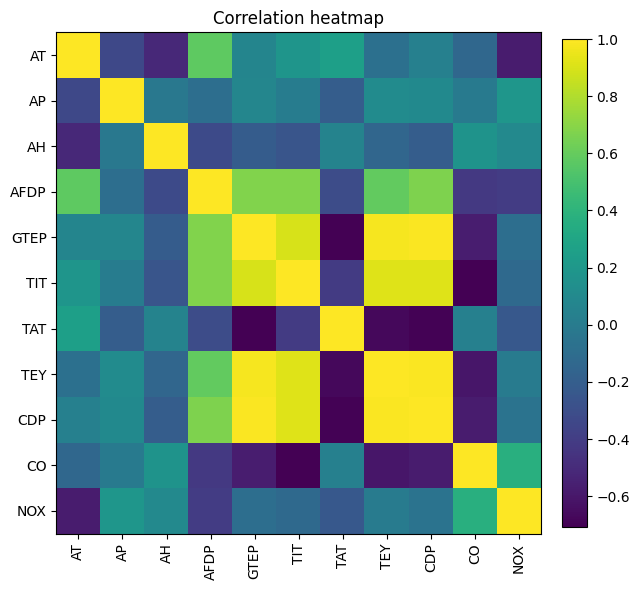

Top |corr| with NOX:


NOX     1.000000
AT      0.576477
AFDP    0.406751
CO      0.371760
TAT     0.236343
AP      0.187986
TIT     0.124142
AH      0.096576
GTEP    0.089365
CDP     0.054180
TEY     0.000064
Name: NOX, dtype: float64

In [9]:
fig, ax = plt.subplots(figsize=(6.5,6))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(corr.columns))); ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90); ax.set_yticklabels(corr.columns)
ax.set_title("Correlation heatmap")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout(); plt.show()

print("Top |corr| with NOX:")
corr['NOX'].abs().sort_values(ascending=False)


Plot NOX against likely drivers to see shape and regimes: TIT, TAT, CDP, TEY, AT, AH, AP, AFDP, GTEP, CO.


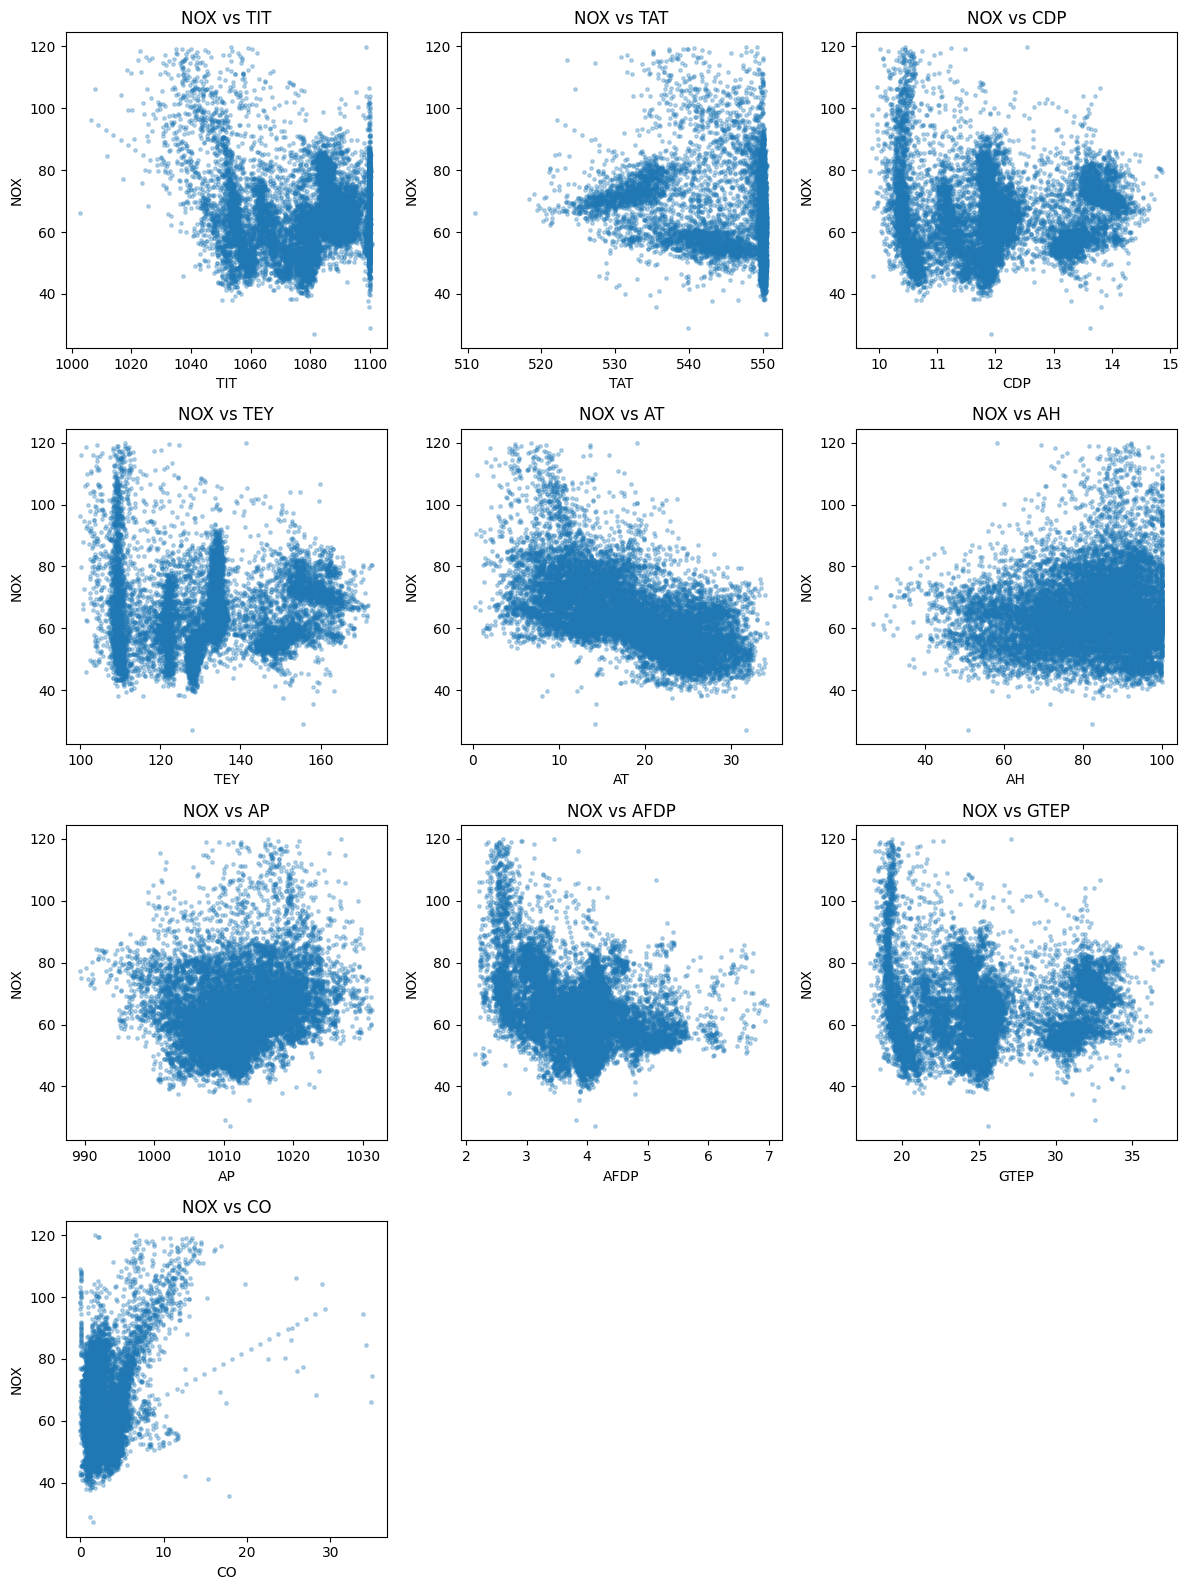

In [10]:
key = ["TIT","TAT","CDP","TEY","AT","AH","AP","AFDP","GTEP","CO"]
rows = int(np.ceil(len(key)/3))
fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))
axes = axes.flatten()

for i, c in enumerate(key):
    axes[i].scatter(df[c], df["NOX"], s=6, alpha=0.3)
    axes[i].set_xlabel(c); axes[i].set_ylabel("NOX"); axes[i].set_title(f"NOX vs {c}")

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.tight_layout(); plt.show()


Check CO–NOX relationship for combustion trade-offs. Create load bands from TEY to see NOX behavior at higher load.


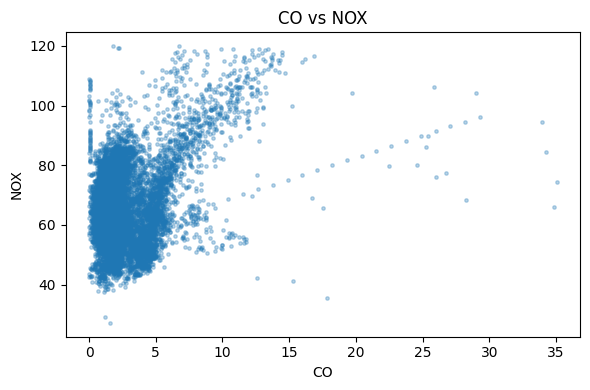

/var/folders/n5/50bl5l7j7nx717mns6lylg800000gn/T/ipykernel_37511/2717462774.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=bands.cat.categories, showfliers=False)


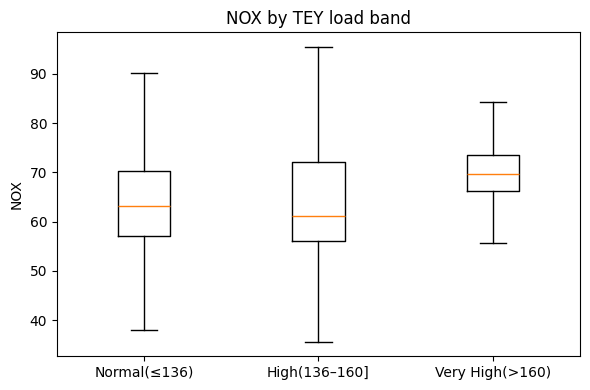

In [11]:
# CO vs NOX
plt.figure(figsize=(6,4))
plt.scatter(df["CO"], df["NOX"], s=6, alpha=0.3)
plt.xlabel("CO"); plt.ylabel("NOX"); plt.title("CO vs NOX")
plt.tight_layout(); plt.show()

# Load bands by TEY (tune thresholds as needed)
low, high = 136, 160
bands = pd.cut(df["TEY"], bins=[-np.inf, low, high, np.inf],
               labels=["Normal(≤136)","High(136–160]","Very High(>160)"])
df["_band"] = bands

# Boxplot NOX by load band
groups = [df.loc[df["_band"]==lab, "NOX"].values for lab in bands.cat.categories]
plt.figure(figsize=(6,4))
plt.boxplot(groups, labels=bands.cat.categories, showfliers=False)
plt.ylabel("NOX"); plt.title("NOX by TEY load band")
plt.tight_layout(); plt.show()


Flag extreme outliers with robust z-score rule. Compare NOX distributions before/after to gauge impact. Keep original for traceability.


Possible outliers: 194
Rows after removing flagged outliers: (14116, 12)


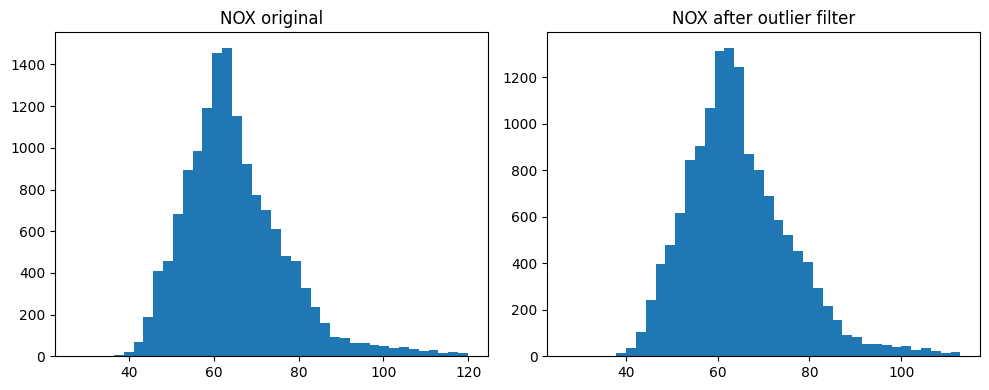

In [12]:
from scipy.stats import zscore

z = df.select_dtypes(float).apply(zscore)
outlier_mask = (z.abs() > 4).any(axis=1)  # conservative
print("Possible outliers:", int(outlier_mask.sum()))

df_clean = df.loc[~outlier_mask].copy()
print("Rows after removing flagged outliers:", df_clean.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(df["NOX"], bins=40); plt.title("NOX original")
plt.subplot(1,2,2); plt.hist(df_clean["NOX"], bins=40); plt.title("NOX after outlier filter")
plt.tight_layout(); plt.show()


Run simple baselines to see which variables matter: Linear Regression (scaled) and RandomForest for nonlinearity.
Report R² and MAE. Plot top RF importances.


Linear  -> R2: 0.592  MAE: 5.207
RF      -> R2: 0.896  MAE: 2.317

Top Linear Coefficients:


TIT     16.817477
TEY     12.385221
AT      10.152597
CO       6.024746
TAT      4.597932
GTEP     3.520111
AH       3.197790
AFDP     0.948726
AP       0.723566
CDP      0.216028
dtype: float64


Top RandomForest Features:


AT      0.351307
CO      0.266909
AFDP    0.099531
TEY     0.091007
TIT     0.058648
AH      0.036546
GTEP    0.032501
AP      0.026745
TAT     0.023190
CDP     0.013617
dtype: float64

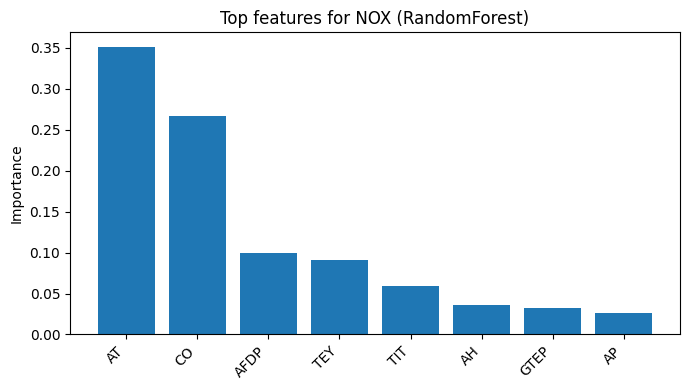

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Use only numeric predictors
target = "NOX"
X = df.select_dtypes(include=[np.number]).drop(columns=[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression with scaling
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)
lin = LinearRegression().fit(Xtr, y_train)
pred_lin = lin.predict(Xte)

# Random Forest
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print(f"Linear  -> R2: {r2_score(y_test, pred_lin):.3f}  MAE: {mean_absolute_error(y_test, pred_lin):.3f}")
print(f"RF      -> R2: {r2_score(y_test, pred_rf):.3f}  MAE: {mean_absolute_error(y_test, pred_rf):.3f}")

# Feature importance
coef_abs = pd.Series(np.abs(lin.coef_), index=X.columns).sort_values(ascending=False)
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nTop Linear Coefficients:")
display(coef_abs.head(10))

print("\nTop RandomForest Features:")
display(imp.head(10))

# Plot RF importances
top = imp.head(8)
plt.figure(figsize=(7,4))
plt.bar(top.index, top.values)
plt.title("Top features for NOX (RandomForest)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Use correlations, scatter shapes, load-band boxplots, and feature importances to:
• Identify primary levers (e.g., TIT, CDP, TEY, CO).
• Quantify CO–NOX trade-offs.
• Define candidate control/retrofit hypotheses for NOx reduction.
Next: scenario tests (ΔTIT, ΔTEY), cross-validation, and a clean sklearn Pipeline for reproducible modeling.